<a href="https://colab.research.google.com/github/timonpalm/TFCourse/blob/main/05_transfer_learning_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning: Fine-Tuning

In [2]:
! nvidia-smi

Mon Nov 13 16:27:19 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
#! wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [4]:
# import helper function
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

## Let's get some data

In [5]:
#!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

#unzip_data("10_food_classes_10_percent.zip")

In [6]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/gri

In [7]:
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [8]:
import tensorflow as tf

IMG_SIZE = (224,224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical",
                                                                batch_size=BATCH_SIZE
                                                                )

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [9]:
train_data_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [10]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [11]:
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[2.54000000e+02 2.54000000e+02 2.54000000e+02]
   [2.54000000e+02 2.54000000e+02 2.54000000e+02]
   [2.54000000e+02 2.54000000e+02 2.54000000e+02]
   ...
   [1.69495239e+02 1.48505341e+02 1.00500259e+02]
   [1.42101303e+02 1.07412453e+02 6.87441559e+01]
   [7.09336472e+01 2.59335766e+01 4.59158778e-01]]

  [[2.54000000e+02 2.54000000e+02 2.54000000e+02]
   [2.54000000e+02 2.54000000e+02 2.54000000e+02]
   [2.54000000e+02 2.54000000e+02 2.54000000e+02]
   ...
   [1.64882782e+02 1.44852097e+02 9.17245178e+01]
   [1.69147629e+02 1.38071045e+02 9.22088776e+01]
   [8.07639160e+01 4.24067039e+01 1.28105288e+01]]

  [[2.54000000e+02 2.54000000e+02 2.54000000e+02]
   [2.54000000e+02 2.54000000e+02 2.54000000e+02]
   [2.54000000e+02 2.54000000e+02 2.54000000e+02]
   ...
   [1.62055908e+02 1.45504883e+02 8.49589005e+01]
   [2.00040543e+02 1.76341492e+02 1.21310966e+02]
   [1.08978302e+02 7.89118805e+01 3.41518860e+01]]

  ...

  [[2.53785706e+02 2.54785706e+02 2.23785706e+02]
   [2

# Using tf.keras.Sequential

In [25]:
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(
    #classes=10,
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    pooling="avg"
    )
base_model.trainable = False # don't train base_model

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Dense(10, activation="softmax")
])

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=["accuracy"])

In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b0 (Functio  (None, 1280)              5919312   
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 10)                12810     
                                                                 
Total params: 5932122 (22.63 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 5919312 (22.58 MB)
_________________________________________________________________


In [27]:
history1 = model.fit(train_data_10_percent,
          steps_per_epoch=len(train_data_10_percent),
          epochs=5,
          validation_data=test_data,
          validation_steps=len(test_data),
          callbacks=[create_tensorboard_callback("model_hub", "effnet_sequ")])

Saving TensorBoard log files to: model_hub/effnet_sequ/20231113-164829
Epoch 1/5
24/24 [==============================] - 19s 378ms/step - loss: 1.8706 - accuracy: 0.4547 - val_loss: 1.3038 - val_accuracy: 0.7464
Epoch 2/5
24/24 [==============================] - 9s 339ms/step - loss: 1.1395 - accuracy: 0.7533 - val_loss: 0.8971 - val_accuracy: 0.8124
Epoch 3/5
24/24 [==============================] - 11s 440ms/step - loss: 0.8426 - accuracy: 0.8227 - val_loss: 0.7162 - val_accuracy: 0.8340
Epoch 4/5
24/24 [==============================] - 7s 300ms/step - loss: 0.6916 - accuracy: 0.8400 - val_loss: 0.6277 - val_accuracy: 0.8500
Epoch 5/5
24/24 [==============================] - 9s 372ms/step - loss: 0.5829 - accuracy: 0.8747 - val_loss: 0.5680 - val_accuracy: 0.8572


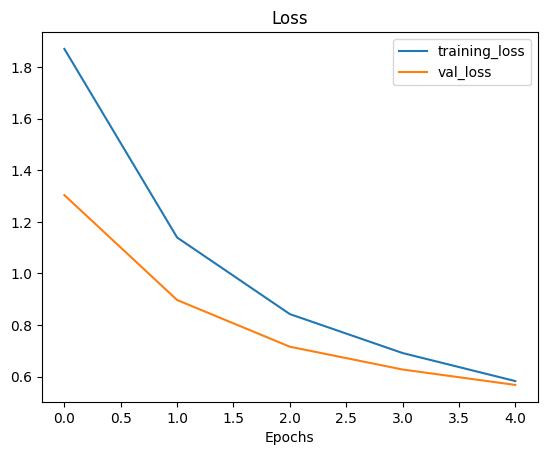

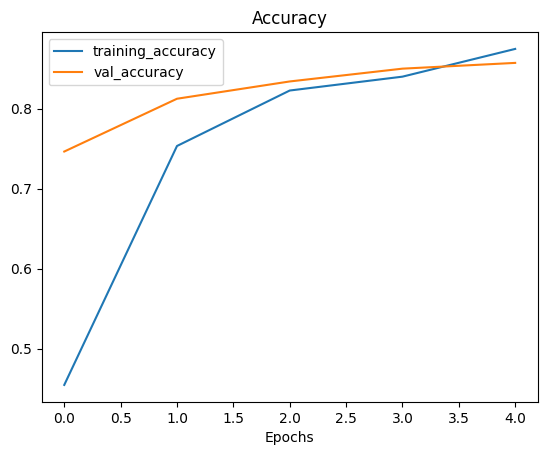

In [28]:
plot_loss_curves(history1)

# Using Functional API

In [18]:
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(
    #classes=10,
    #input_shape=IMG_SIZE + (3,),
    include_top=False,
    #pooling="max"
    )

base_model.trainable = False

inputs = tf.keras.layers.Input(shape=IMG_SIZE + (3,), name="input_layer")

# x = tf.keras.layers.experimental.preprocessing.Rescaling(1/255.)(inputs)

x = base_model(inputs)

x = tf.keras.layers.GlobalAveragePooling2D(name="globalPooling")(x)

outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

model_1 = tf.keras.Model(inputs, outputs)

In [19]:
model_1.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=["accuracy"])

history_1 = model_1.fit(train_data_10_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data,
                        validation_steps=len(test_data),
                        callbacks=[create_tensorboard_callback("model_hub", "effnet_func")])

Saving TensorBoard log files to: model_hub/effnet_func/20231113-164509
Epoch 1/5
24/24 [==============================] - 26s 580ms/step - loss: 1.9140 - accuracy: 0.3947 - val_loss: 1.3449 - val_accuracy: 0.7224
Epoch 2/5
24/24 [==============================] - 9s 352ms/step - loss: 1.1755 - accuracy: 0.7373 - val_loss: 0.9124 - val_accuracy: 0.8068
Epoch 3/5
24/24 [==============================] - 12s 508ms/step - loss: 0.8654 - accuracy: 0.8067 - val_loss: 0.7291 - val_accuracy: 0.8408
Epoch 4/5
24/24 [==============================] - 7s 284ms/step - loss: 0.6992 - accuracy: 0.8480 - val_loss: 0.6330 - val_accuracy: 0.8544
Epoch 5/5
24/24 [==============================] - 10s 430ms/step - loss: 0.6046 - accuracy: 0.8667 - val_loss: 0.5760 - val_accuracy: 0.8592


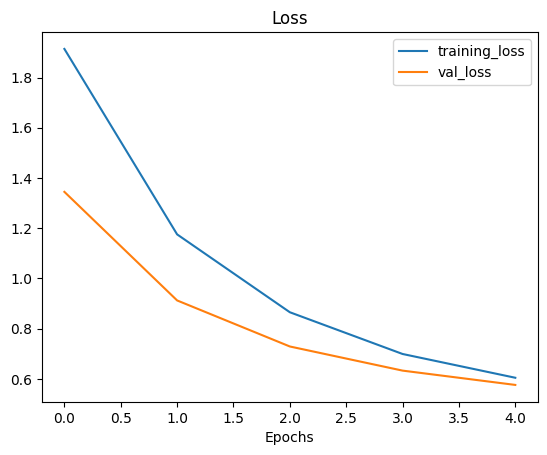

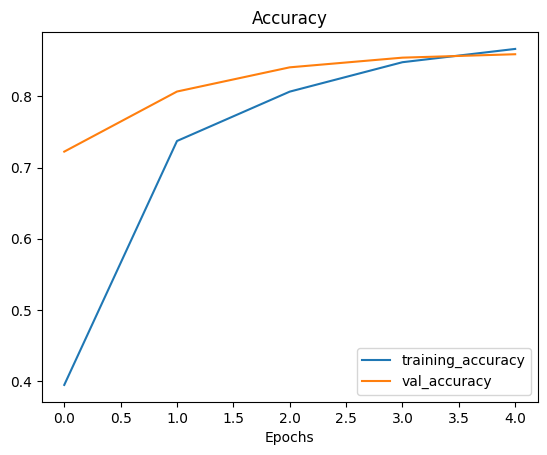

In [20]:
plot_loss_curves(history_1)